# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

You should consider upgrading via the 'D:\ANPR\anprsys\Scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
import object_detection

# 2. Create Label Map

In [8]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 5. Update Config For Transfer Learning

In [9]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [10]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

# 8. Load Train Model From Checkpoint

In [11]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-10')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [13]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [15]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars425.png')

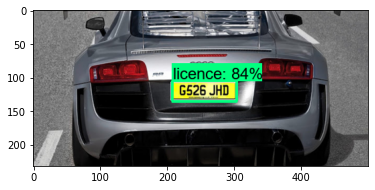

In [16]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR to Detection

In [17]:
import easyocr

In [18]:
detection_threshold = 0.7

In [19]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [20]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.4547739 0.4151927 0.5846603 0.6098216]
[105.50754547 207.59634674 135.64118767 304.9108088 ]
[([[8, 2], [88, 2], [88, 26], [8, 26]], '6526 JHD', 0.5535473751025439)]


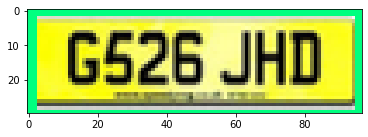

In [21]:
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [22]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

24
6526 JHD


In [23]:
region_threshold = 0.6

In [24]:
region_threshold = 0.05

In [25]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [26]:
filter_text(region, ocr_result, region_threshold)

['6526 JHD']

In [27]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


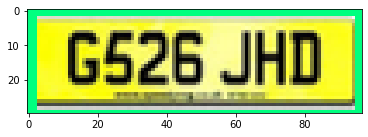

['6526 JHD']


In [28]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Connect SQL

In [29]:
import pymysql 

In [30]:
db = pymysql.connect(host='localhost',user='root',password='zxc133',db='aiot',charset='utf8')

In [31]:
cursor = db.cursor()

In [32]:
cursor.execute(("SELECT storage FROM aiot.product where sku='E38-425' "))
data = cursor.fetchone()
print(data[0])

B


# Connect Servo

In [33]:
from pyfirmata import *
from time import sleep

In [34]:
port = "COM4"
pin_1 = 8
pin_2 = 9
board = Arduino(port)

board.digital[pin_1].mode=SERVO
board.digital[pin_2].mode=SERVO
def rotateservo(pin,angle):
    board.digital[pin_1].write(angle)
    board.digital[pin_2].write(angle)
    sleep(0.015)

In [45]:
while True:
    
    x = input("input :")
    if x == "1":
        rotateservo(pin_1, 0)
        rotateservo(pin_2, 0)
    elif x == "2":
        rotateservo(pin_1, 30)
        rotateservo(pin_2, 30)
    elif x == "3":
        rotateservo(pin_1, 70)
        rotateservo(pin_2, 70)
    else:
        break

input :1
input :2
input :3
input :2
input :1
input :3
input :2
input :3
input :1
input :2
input :0


# Save result

In [36]:
import csv
import uuid

In [37]:
def save_results(result_p, region, data1, csv_filename, folder_path):
    img_name = '1.jpg'
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='\n') as f:
        csv_writer = csv.DictWriter(f, ['A','number','class'])
        csv_writer.writerow({'A':str(img_name),'number':result_p,'class':str(data1)})

In [38]:
data

('B',)

In [39]:
data1=data[0]

In [40]:
data1

'B'

In [41]:
text

['6526 JHD']

In [42]:
save_results(text, region ,data1, 'detection_results.csv', 'Detection_Images')

# 10. Real Time Detections from your Webcam

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


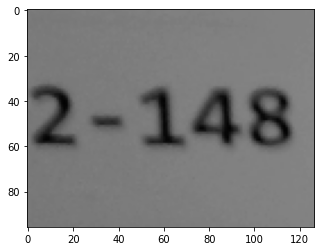

['2-148']
2-148


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


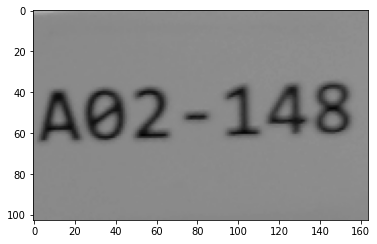

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['A02-148']
A02-148
C


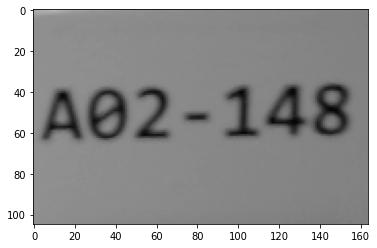

['A02-148']
A02-148
C


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


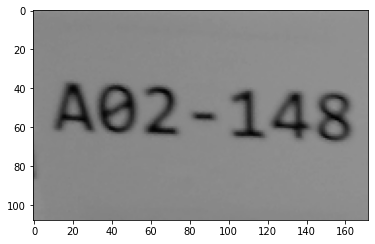

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['A02-148']
A02-148
C


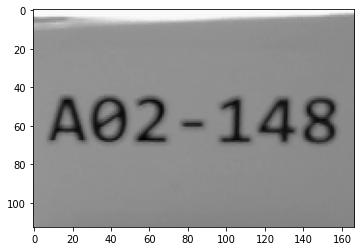

['A02-148']
A02-148
C


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


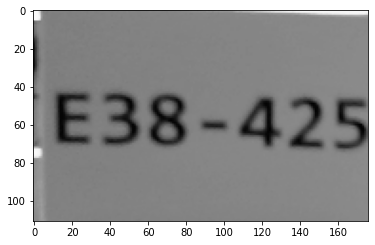

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['E38-425']
E38-425
B


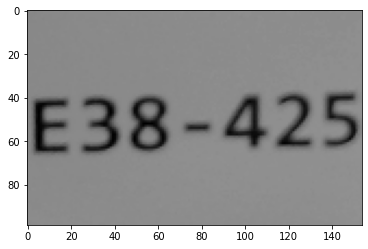

['E38-425']
E38-425
B


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


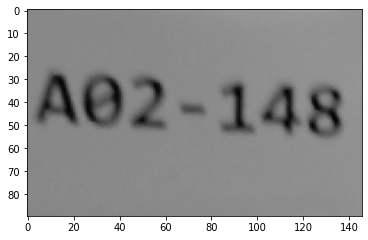

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['A0z-148']
A0z-148


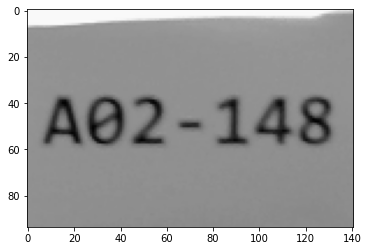

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['A02-148']
A02-148
C


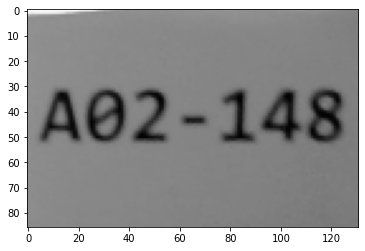

['A02-148']
A02-148
C


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


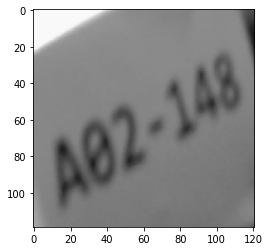

['(402-1481']
(402-1481


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


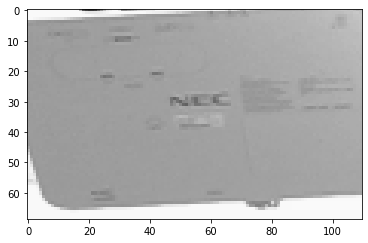

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


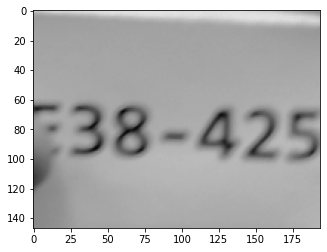

['738-425']
738-425


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


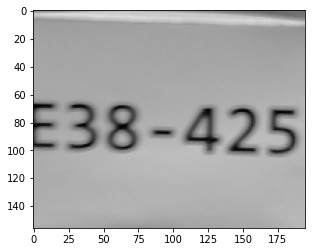

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['[38-425']
[38-425


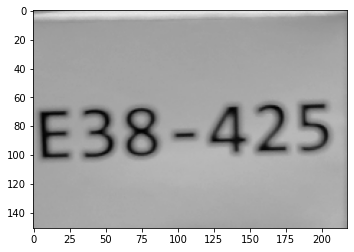

['E38-425']
E38-425
B


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


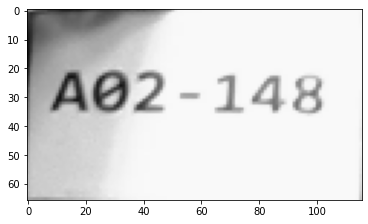

['A02', '148']
A02


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


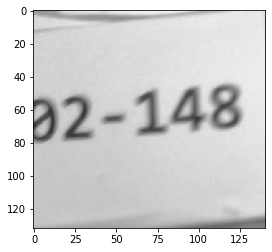

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['92-148']
92-148


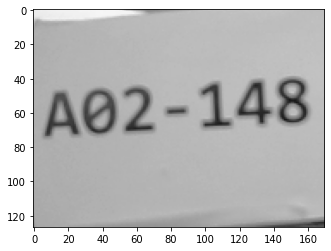

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['A02-148']
A02-148
C


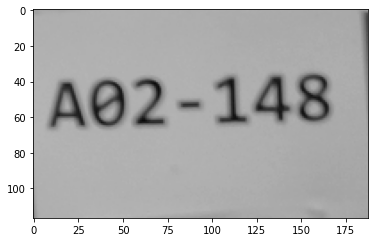

['A02-148']
A02-148
C


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


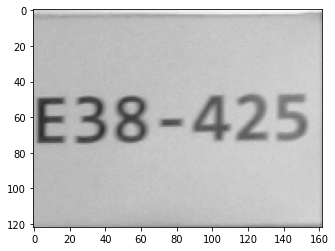

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['E38-425']
E38-425
B


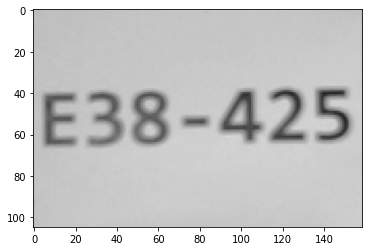

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['E38-425']
E38-425
B


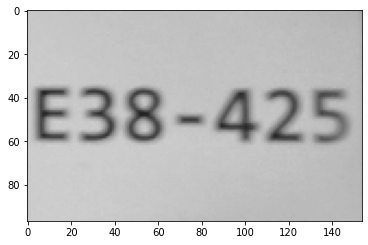

['E38-425']
E38-425
B


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


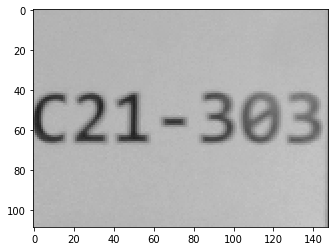

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['C21-303']
C21-303
A


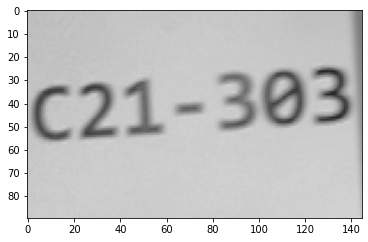

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['C21-303']
C21-303
A


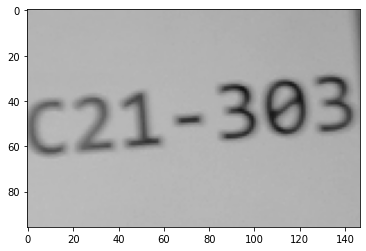

['C21-303']
C21-303
A


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


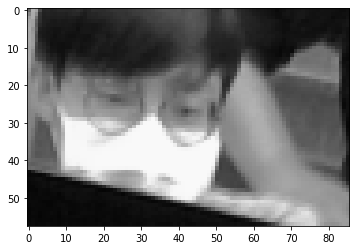

[]


In [46]:
import pymysql 
db = pymysql.connect(host='localhost',user='root',password='zxc133',db='aiot',charset='utf8')
cursor = db.cursor()
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    img_11 = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2GRAY) 

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    try: 
        text, region = ocr_it(img_11, detections, detection_threshold, region_threshold)
        result_p=str(text[0])
        print(result_p)
#         x=f"SELECT product_level FROM products where product_id='{result_p}'"
#         print(x)
        cursor.execute((f"SELECT storage FROM aiot.product where sku='{result_p}'"))
        data = cursor.fetchone()
        print(data[0])
        data1=data[0]
        if data1 == "A":
            rotateservo(pin_1, 0)
            rotateservo(pin_2, 0)
        elif data1 == "B":
            rotateservo(pin_1, 30)
            rotateservo(pin_2, 30)
        elif data1 == "C":
            rotateservo(pin_1, 70)
            rotateservo(pin_2, 60)
        save_results(text, region ,data1, 'detection_results.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break



In [ ]:
import pymysql 
db = pymysql.connect(host='localhost',user='root',password='zxc133',db='aiot',charset='utf8')
cursor = db.cursor()
cap = cv2.VideoCapture(1)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
json = {}

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    img11 = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2GRAY) 

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    try: 
        text, region = ocr_it(img11, detections, detection_threshold, region_threshold)
        result=str(text[0])
        print(result)
#         x=f"SELECT product_level FROM products where product_id='{result_p}'"
#         print(x)
        cursor.execute((f"SELECT storage FROM aiot.product where sku='{result}'"))
        data = cursor.fetchone()
        data1 = data[0]
        print(data1)
        if data1 == "A":
            rotateservo(pin_1, 0)
            rotateservo(pin_2, 0)
        elif data1 == "B":
            rotateservo(pin_1, 30)
            rotateservo(pin_2, 30)
        elif data1 == "C":
            rotateservo(pin_1, 70)
            rotateservo(pin_2, 60)
        save_results(text, region ,data1, 'detection_results.csv', 'Detection_Images')
#             json["result"] = result
#             json["data1"] = data1
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
#         json["result"] = result
#         json["data1"] = data1

